In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:

df = pd.read_csv("/content/drive/MyDrive/ Dataset/Sample - Superstore.csv", encoding="ISO-8859-1")

In [4]:
df["Order Date"] = pd.to_datetime(df["Order Date"])
df = df.sort_values("Order Date")

In [5]:
# STEP 3: Aggregate to MONTHLY sales
# Why? ARIMA/SARIMA works better on a single regular time series.
# We use month-start frequency ("MS") so dates look like 2017-01-01, 2017-02-01, etc.
# ------------------------------------------------------------
monthly_sales = (
    df.set_index("Order Date")
      .resample("MS")["Sales"]
      .sum()
)

In [6]:
# Optional: make sure index is a standard Timestamp index (not needed but nice)
monthly_sales.index = monthly_sales.index.to_period("M").to_timestamp()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


=== SARIMA Accuracy on last 12 months ===
MAE : 13,580.18
RMSE: 16,260.70
MAPE: 26.84%

=== Actual vs Forecast (Last 12 months) ===
            Actual Sales  SARIMA Forecast  Lower CI   Upper CI
Order Date                                                    
2017-01-01      43971.37         27758.79   5615.58   49901.99
2017-02-01      20301.13         35250.33  12524.80   57975.86
2017-03-01      58872.35         63192.01  40383.30   86000.73
2017-04-01      36521.54         50236.35  27433.62   73039.09
2017-05-01      44261.11         68472.90  45667.82   91277.98
2017-06-01      52981.73         51773.19  28969.01   74577.38
2017-07-01      45264.42         50600.79  27796.76   73404.83
2017-08-01      63120.89         42287.48  19483.87   65091.10
2017-09-01      87866.65         84754.69  61951.51  107557.87
2017-10-01      77776.92         71058.68  48256.06   93861.30
2017-11-01     118447.82         90723.62  67921.69  113525.56
2017-12-01      83829.32        108450.69  85649.

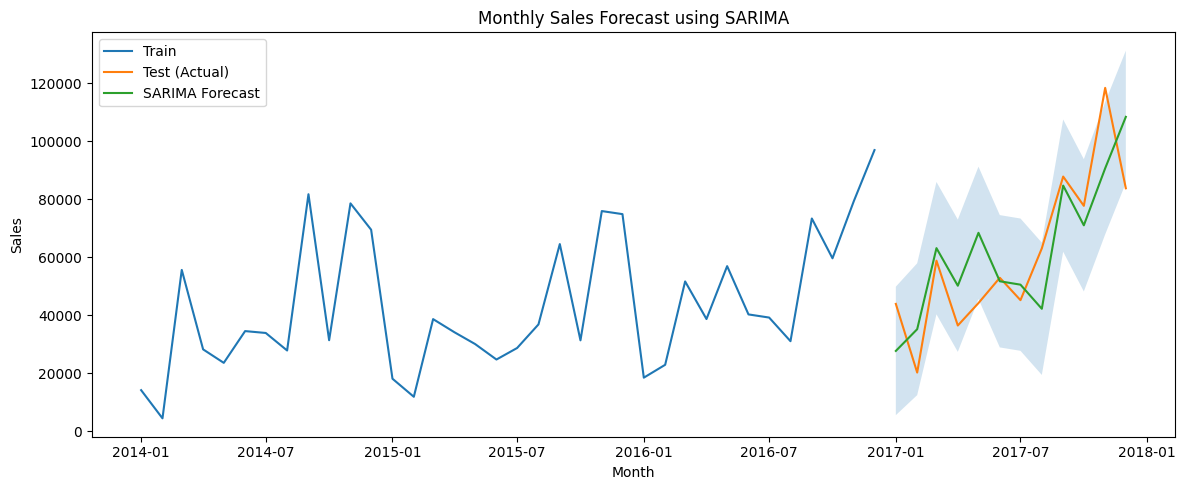

In [7]:


# ------------------------------------------------------------
# STEP 4: Train-Test split (time-based)
# We keep the last 12 months as test data to simulate real forecasting
# ------------------------------------------------------------
train = monthly_sales[:-12]
test  = monthly_sales[-12:]

# ------------------------------------------------------------
# STEP 5: Fit SARIMA model
# SARIMA = ARIMA + Seasonality
#
# order=(p,d,q) -> (1,1,1): non-seasonal behaviour (trend + short-term memory)
# seasonal_order=(P,D,Q,s) -> (1,1,1,12): seasonal behaviour repeating every 12 months
#
# enforce_stationarity=False and enforce_invertibility=False help the model fit more flexibly
# ------------------------------------------------------------
sarima_model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)

# ------------------------------------------------------------
# STEP 6: Forecast the next 12 months (same length as test set)
# get_forecast gives predictions + confidence intervals
# ------------------------------------------------------------
forecast_obj = sarima_fit.get_forecast(steps=12)
forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# ------------------------------------------------------------
# STEP 7: Evaluate accuracy
# MAE: average absolute error
# RMSE: penalizes big errors
# MAPE: percentage error (be careful if you have near-zero values; here it's fine)
# ------------------------------------------------------------
mae  = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / np.clip(np.abs(test), 1e-9, None))) * 100

print("=== SARIMA Accuracy on last 12 months ===")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:,.2f}%")

# ------------------------------------------------------------
# STEP 8: Create final result table (Actual vs Forecast)
# This is the exact output you can export to Power BI/Tableau
# ------------------------------------------------------------
result = pd.DataFrame({
    "Actual Sales": test.values,
    "SARIMA Forecast": forecast.values,
    "Lower CI": conf_int.iloc[:, 0].values,
    "Upper CI": conf_int.iloc[:, 1].values
}, index=test.index)

print("\n=== Actual vs Forecast (Last 12 months) ===")
print(result.round(2))

# ------------------------------------------------------------
# STEP 9: Plot the historical sales, forecast, and confidence band
# ------------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test (Actual)")
plt.plot(forecast.index, forecast.values, label="SARIMA Forecast")

# confidence interval shading
plt.fill_between(
    forecast.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    alpha=0.2
)

plt.title("Monthly Sales Forecast using SARIMA")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()